# Reduccion de la dimensionalidad

In [68]:
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [3]:
# Lee el archivo movies_combined_features.npz y conviertelo a un DataFrame de pandas
data = np.load('movies_combined_features.npz', allow_pickle=True)


In [4]:
# Crear DataFrame
df = pd.DataFrame({
    "movieId": data["movieId"],
    "title": data["title"],
    "features": list(data["features"])
})

print(df.head())
print(f"\n✅ Total de películas: {len(df)}")
print(f"✅ Dimensión del vector de features: {len(df['features'][0])}")

  movieId                        title  \
0     619                    Ed (1996)   
1   33826           Saint Ralph (2004)   
2  140289         Men & Chicken (2015)   
3    2868  Fright Night Part II (1988)   
4   27826         Touch of Pink (2004)   

                                            features  
0  [0.19058356, 0.0979772, 0.076737955, 0.2980004...  
1  [0.7005998, 0.025042623, 0.017594602, 0.319023...  
2  [0.5831317, 0.35357442, 0.23846312, 0.5706941,...  
3  [0.0803354, 0.012563372, 0.0074199205, 0.00971...  
4  [0.4992489, 0.25805205, 0.26244, 0.43175837, 0...  

✅ Total de películas: 5831
✅ Dimensión del vector de features: 305


In [5]:
df.to_parquet("movies_combined_features.parquet", index=False)

In [6]:
X = df['features']
X

0       [0.19058356, 0.0979772, 0.076737955, 0.2980004...
1       [0.7005998, 0.025042623, 0.017594602, 0.319023...
2       [0.5831317, 0.35357442, 0.23846312, 0.5706941,...
3       [0.0803354, 0.012563372, 0.0074199205, 0.00971...
4       [0.4992489, 0.25805205, 0.26244, 0.43175837, 0...
                              ...                        
5826    [0.7714135, 0.24436931, 0.12911719, 0.14526577...
5827    [0.2392464, 0.35585207, 0.4505439, 0.5198439, ...
5828    [0.023544967, 0.033031892, 0.03903918, 0.05568...
5829    [0.45437413, 0.34345305, 0.27206698, 0.5387123...
5830    [0.002580927, 0.0026351197, 0.016318774, 0.591...
Name: features, Length: 5831, dtype: object

## Primer método: PCA

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [15]:
# 1. Preparar los datos
def preparar_datos(df):
    """
    Convierte la columna 'features' en un array numpy y escala los datos
    """
    # Convertir features a array numpy si no lo está
    if isinstance(df['features'].iloc[0], list):
        features_array = np.array(df['features'].tolist())
    else:
        features_array = df['features'].values

    # Ensure features_array is a 2D array
    features_array = np.array(features_array.tolist())

    # Escalar los datos (importante para PCA)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_array)

    return features_scaled, scaler

In [29]:
# 2. Reducción con PCA conservando varianza
def aplicar_pca_varianza(features, varianza_objetivo=0.90):
    """
    Aplica PCA conservando un porcentaje específico de varianza
    """
    # PCA sin número fijo de componentes
    pca = PCA()
    features_pca = pca.fit_transform(features)
    
    # Calcular varianza acumulada
    varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)
    
    # Encontrar número de componentes que alcanzan la varianza objetivo
    n_componentes = np.argmax(varianza_acumulada >= varianza_objetivo) + 1
    
    print(f"Varianza objetivo: {varianza_objetivo*100}%")
    print(f"Número de componentes necesarios: {n_componentes}")
    print(f"Varianza explicada con {n_componentes} componentes: {varianza_acumulada[n_componentes-1]:.4f}")
    
    # Re-aplicar PCA con el número exacto de componentes
    pca_final = PCA(n_components=n_componentes)
    features_pca_final = pca_final.fit_transform(features)
    
    return features_pca_final, pca_final, varianza_acumulada

In [22]:
# 3. Visualización con t-SNE
def visualizar_tsne(features_reducidos, titulos=None, mostrar_titulos=False):
    """
    Aplica t-SNE para visualización 2D y crea gráfico
    """
    # Aplicar t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_tsne = tsne.fit_transform(features_reducidos)
    
    # Crear gráfico
    plt.figure(figsize=(12, 8))
    
    if mostrar_titulos and titulos is not None:
        # Scatter plot con puntos más pequeños para ver los títulos
        scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], 
                            alpha=0.6, s=30, cmap='viridis')
        
        # Añadir algunos títulos de ejemplo (evitar sobrecargar)
        rng = np.random.RandomState(42)
        indices_ejemplo = rng.choice(len(titulos), size=min(20, len(titulos)), replace=False)
        
        for idx in indices_ejemplo:
            plt.annotate(titulos[idx], 
                        (features_tsne[idx, 0], features_tsne[idx, 1]),
                        fontsize=8, alpha=0.7)
    else:
        # Scatter plot normal
        scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], 
                            alpha=0.7, s=50, cmap='viridis')
    
    plt.title('Visualización t-SNE de Posters de Películas')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.colorbar(scatter, label='Densidad')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return features_tsne

In [34]:
# 4. Análisis de varianza PCA
def graficar_varianza_pca(varianza_acumulada):
    """
    Gráfico de varianza explicada por componentes PCA
    """
    plt.figure(figsize=(10, 6))
    
    plt.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, 
             'b-', linewidth=2, label='Varianza Acumulada')
    plt.axhline(y=0.90, color='r', linestyle='--', label='90% Varianza')
    
    # Encontrar donde cruza el 95%
    idx_95 = np.argmax(varianza_acumulada >= 0.90)
    plt.axvline(x=idx_95 + 1, color='r', linestyle='--', alpha=0.7)
    
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.title('Análisis de Varianza PCA')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [32]:
# 5. Función principal
def pipeline_reduccion_visualizacion(df, varianza_objetivo=0.90):
    """
    Pipeline completo de reducción y visualización
    """
    print("=== INICIANDO PIPELINE DE REDUCCIÓN Y VISUALIZACIÓN ===\n")
    
    # Paso 1: Preparar datos
    print("1. Preparando datos...")
    features_scaled, scaler = preparar_datos(df)
    print(f"   Dimensiones originales: {features_scaled.shape}")
    
    # Paso 2: Aplicar PCA
    print("\n2. Aplicando PCA...")
    features_pca, pca_model, varianza_acumulada = aplicar_pca_varianza(
        features_scaled, varianza_objetivo
    )
    print(f"   Dimensiones después de PCA: {features_pca.shape}")
    
    # Paso 3: Gráfico de varianza
    print("\n3. Generando gráfico de varianza...")
    graficar_varianza_pca(varianza_acumulada)
    
    # Paso 4: Visualización t-SNE
    print("\n4. Aplicando t-SNE para visualización...")
    features_tsne = visualizar_tsne(features_pca, df['title'].values, mostrar_titulos=True)
    
    # Paso 5: Visualización alternativa sin títulos (más limpia)
    print("\n5. Visualización alternativa (sin títulos)...")
    visualizar_tsne(features_pca, mostrar_titulos=False)
    
    # Retornar resultados
    resultados = {
        'features_pca': features_pca,
        'features_tsne': features_tsne,
        'pca_model': pca_model,
        'scaler': scaler,
        'varianza_acumulada': varianza_acumulada
    }
    
    return resultados

=== INICIANDO PIPELINE DE REDUCCIÓN Y VISUALIZACIÓN ===

1. Preparando datos...
   Dimensiones originales: (5831, 305)

2. Aplicando PCA...
Varianza objetivo: 90.0%
Número de componentes necesarios: 90
Varianza explicada con 90 componentes: 0.9008
   Dimensiones después de PCA: (5831, 90)

3. Generando gráfico de varianza...


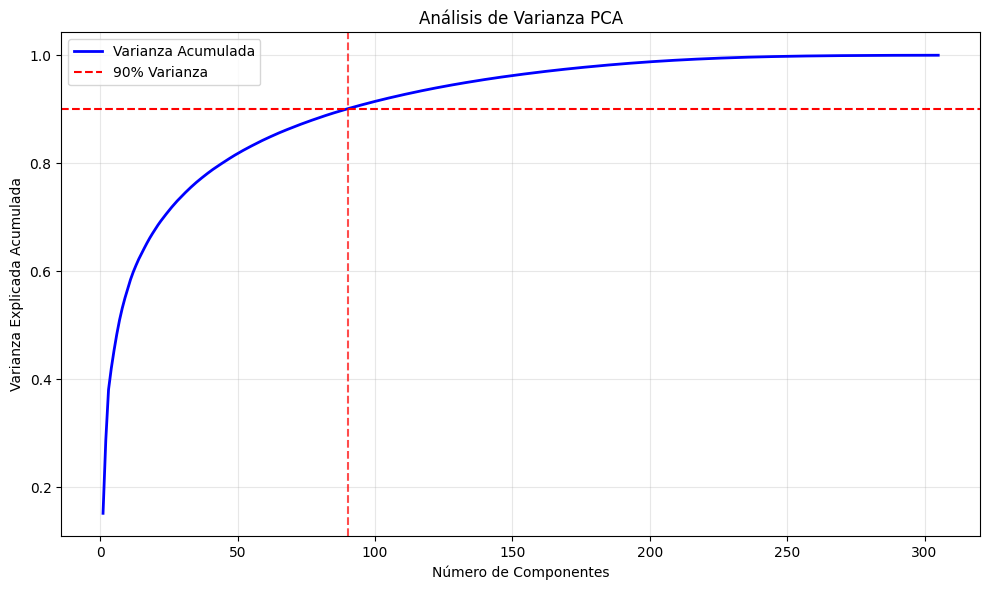


4. Aplicando t-SNE para visualización...


C:\Users\USER\AppData\Local\Temp\ipykernel_11148\3579928852.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1],


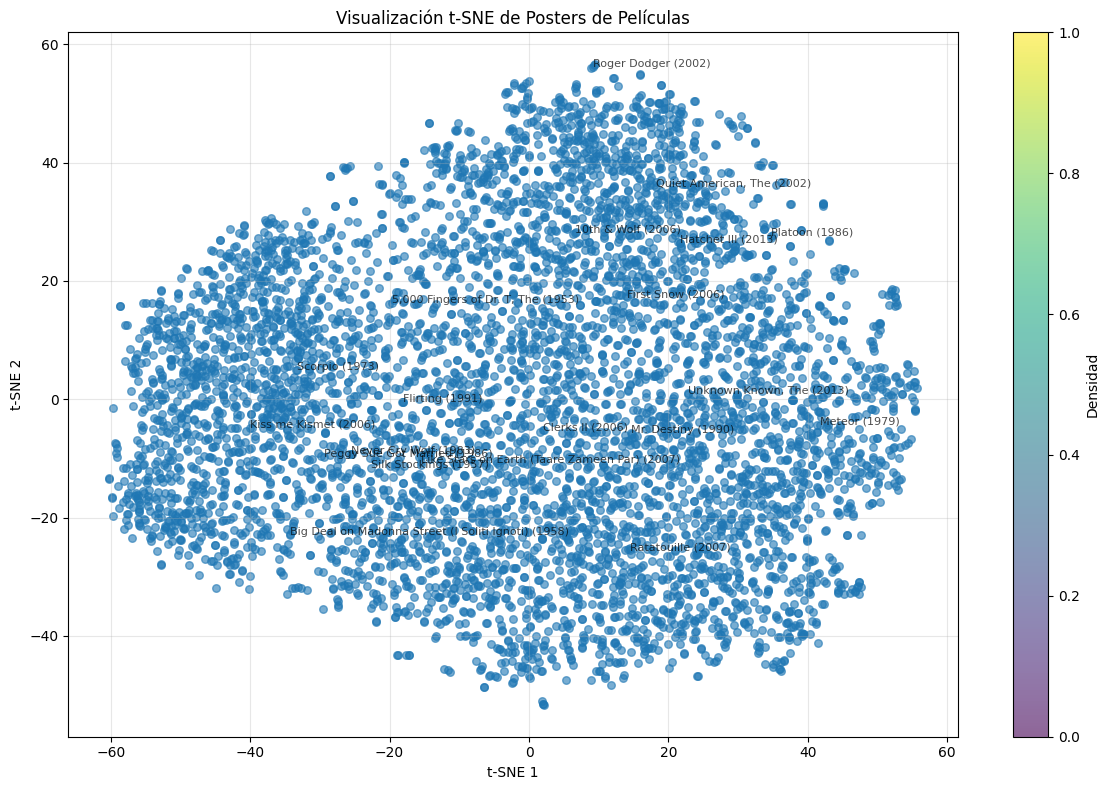


5. Visualización alternativa (sin títulos)...


C:\Users\USER\AppData\Local\Temp\ipykernel_11148\3579928852.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1],


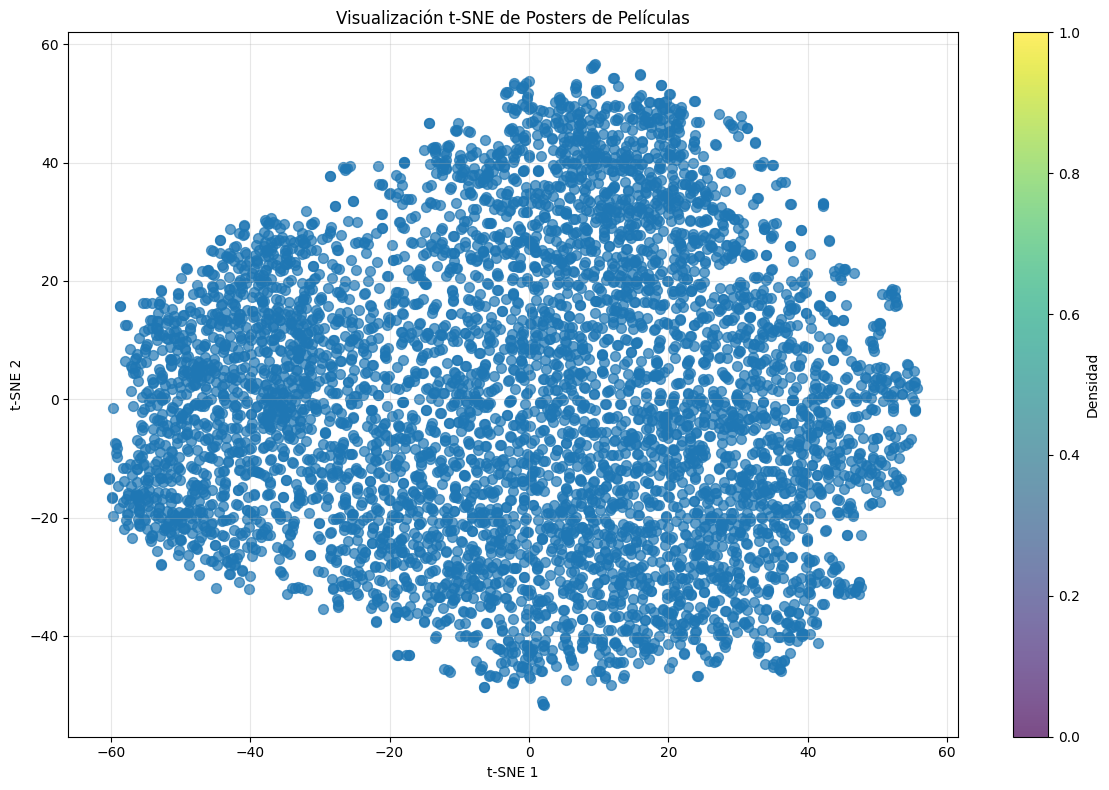


=== PROCESO COMPLETADO ===
Reducción de 305 a 90 dimensiones
Varianza conservada: 0.9008


In [35]:
resultados = pipeline_reduccion_visualizacion(df, varianza_objetivo=0.90)
# Guardar resultados si es necesario
df_resultados = df.copy()
df_resultados['pca_features'] = list(resultados['features_pca'])
df_resultados['tsne_x'] = resultados['features_tsne'][:, 0]
df_resultados['tsne_y'] = resultados['features_tsne'][:, 1]
    
print(f"\n=== PROCESO COMPLETADO ===")
print(f"Reducción de {305} a {resultados['features_pca'].shape[1]} dimensiones")
print(f"Varianza conservada: {resultados['varianza_acumulada'][resultados['features_pca'].shape[1]-1]:.4f}")

In [36]:
df_pca = resultados['features_pca']

In [37]:
PCA_features = pd.DataFrame(df_pca, columns=[f'PCA_{i+1}' for i in range(df_pca.shape[1])])

In [38]:
PCA_features

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_81,PCA_82,PCA_83,PCA_84,PCA_85,PCA_86,PCA_87,PCA_88,PCA_89,PCA_90
0,5.506135,-9.820137,-6.922371,-3.651695,0.763472,-2.586869,-1.122717,2.270080,1.137109,0.065042,...,0.529140,-0.675860,0.652584,-0.422969,-0.324499,-0.402530,-0.209635,-0.553781,0.117893,0.121579
1,-9.269553,-15.366420,6.126430,7.487738,1.485180,-0.131593,-0.577547,-0.539436,-0.319263,1.266533,...,0.155312,-0.116008,-0.660685,-0.109825,-0.175769,0.038308,-0.188315,0.265364,-0.599632,-0.168388
2,6.158485,-8.471273,4.386673,2.442752,-0.455687,0.283006,0.503773,0.642149,0.097381,-2.145893,...,-1.072545,-0.392253,-0.021449,-0.842772,0.863910,0.104372,0.352982,0.723910,0.466636,0.185919
3,8.587379,-1.493288,-4.556343,1.283821,-0.239694,1.700545,3.815788,-0.397125,-0.116148,2.592411,...,-0.141576,0.329706,1.041089,-0.460658,-0.001421,0.246473,-0.560595,-0.304390,-1.764680,-0.736063
4,-4.592663,-7.882254,-2.477958,-2.276199,0.910424,-0.017586,0.795826,-1.259210,-1.269726,-0.385561,...,0.529207,-0.659032,-0.161518,-0.164652,-0.630375,-0.389752,0.327194,0.151800,0.245300,0.334242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5826,-9.919991,3.175613,-1.737323,3.243782,2.011772,4.467297,-0.217136,-1.641691,1.086547,-2.236547,...,0.098530,-0.209280,-0.118885,0.108925,-0.225596,-0.037091,0.389734,0.016629,0.130783,0.084717
5827,-9.293284,2.983634,-4.881362,-1.690759,-4.404477,-1.603422,1.108389,2.192707,-0.190502,0.549881,...,0.361348,0.061909,0.560542,0.828727,0.674138,-0.423233,0.555963,-0.558204,0.661118,0.778599
5828,-5.519200,-3.039271,3.257334,1.768468,3.240196,-0.495983,0.812031,0.606277,1.679699,0.178569,...,-0.603126,-1.410275,-0.730975,-1.020106,-1.269240,0.937448,0.309006,1.768145,-0.800804,-0.050785
5829,5.228898,-1.774336,-1.158354,1.409253,5.010565,1.256647,-2.065342,-2.029046,1.664066,0.544592,...,-0.335921,-0.350503,0.811848,-0.127136,0.774296,0.236583,-0.461953,-0.308197,0.230082,-0.766825


In [39]:
PCA_features.to_csv("movies_pca_features.csv", index=False)

## Segunda técnica: UMAP

In [45]:
import umap

d:\Utec 2025-2\Machine\P2_ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.tolist())

In [71]:

# -------------------------------------------
# 4. UMAP (reducción a 40 dimensiones)
# -------------------------------------------
umap_40d = umap.UMAP(
    n_neighbors=15,
    n_components=50,     # 🔹 Reducción intermedia a 40 dimensiones
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_umap40 = umap_40d.fit_transform(X_scaled)

print("✅ UMAP completado. Nueva forma:", X_umap40.shape)

d:\Utec 2025-2\Machine\P2_ML\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP completado. Nueva forma: (5831, 50)


In [72]:
# -------------------------------------------
# 5. t-SNE 
# -------------------------------------------
tsne_reductor = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42
)
X_tsne = tsne_reductor.fit_transform(X_umap40)

In [75]:
# -------------------------------------------
# 6. Crear DataFrames finales
# -------------------------------------------
df_umap40 = pd.DataFrame(X_umap40, columns=[f"UMAP_{i+1}" for i in range(50)])

df_tsne = pd.DataFrame({
    "movieId": df["movieId"],
    "title": df["title"],
    "TSNE_1": X_tsne[:, 0],
    "TSNE_2": X_tsne[:, 1]
})



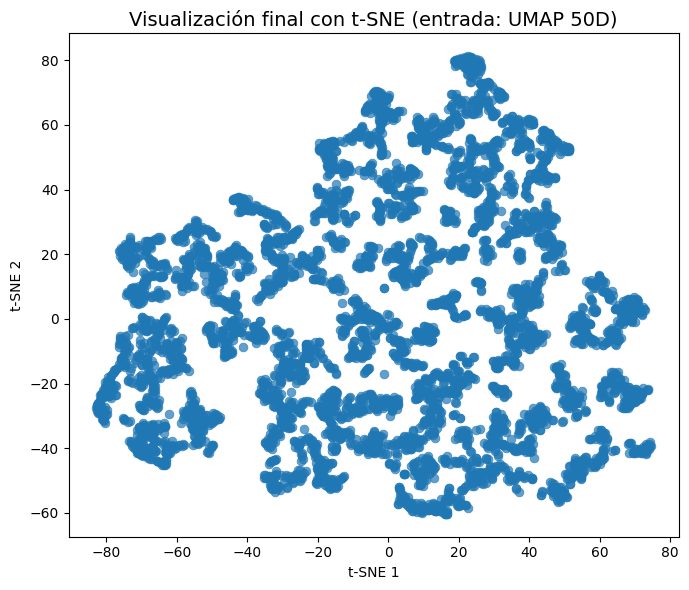

In [76]:
# -------------------------------------------
# 8. Visualización del t-SNE
# -------------------------------------------
plt.figure(figsize=(7, 6))
sns.scatterplot(
    x="TSNE_1", y="TSNE_2",
    data=df_tsne,
    s=40, alpha=0.7, edgecolor=None
)
plt.title("Visualización final con t-SNE (entrada: UMAP 50D)", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

In [77]:
df_umap40.to_csv("movies_umap.csv", index=False)